:::{.callout-note}
## Citation

**This notebook contains analyses for the following project:**

Brunekreef TE, Reteig LC, Limper M, Haitjema S, Dias J, Mathsson-Alm L, van Laar JM, Otten HG. [Microarray analysis of autoantibodies can identify future Systemic Lupus Erythematosus patients](https://doi.org/10.1016/j.humimm.2022.03.010). Human Immunology. 2022 Apr 11. doi:10.1016/j.humimm.2022.03.010
:::

In [1]:
import os
import pandas as pd
import numpy as np
import feather
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sle.modeling import generate_data, prep_data
from sle.penalization import regularization_range, choose_C, regularization_path, plot_regularization_path, coef_plots_regularized
%load_ext autoreload
%autoreload 2

:::{.callout-tip}
## Running the code without the original data

If you want to run the code but don't have access to the data, run the following instead to generate some synthetic data:
:::

```python
data_all = generate_data('imid')
X_test_df = generate_data('rest')
```

In [ ]:
#| code-fold: true
#| code-summary: Code for loading original data
data_dir = os.path.join('..', 'data', 'processed')
data_all = feather.read_dataframe(os.path.join(data_dir, 'imid.feather'))
X_test_df = feather.read_dataframe(os.path.join(data_dir,'rest.feather'))

In [3]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=40)
trf = PowerTransformer(method='box-cox')

In [4]:
y_nefritis = data_all[data_all.Class=='SLE'].Nefritis.astype(np.int64)
X_nefritis = data_all[data_all.Class=='SLE'].drop(["Class"]+["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"], axis=1)

In [5]:
Xp1_nefritis = X_nefritis + 1 # Some < 0 values > -1. Because negative fluorescence isn't possible, and Box-Cox requires strictly positive values, add ofset
X_trf_nefritis = pd.DataFrame(trf.fit_transform(Xp1_nefritis), index=X_nefritis.index, columns=X_nefritis.columns)

In [6]:
clf_lasso = LogisticRegression(penalty='l1', max_iter = 10000, solver = 'liblinear')

In [7]:
K = 100
lambda_min, lambda_max = regularization_range(Xp1_nefritis,y_nefritis,trf)
Cs_lasso_nefritis = np.logspace(np.log10(1/lambda_min),np.log10(1/lambda_max), K)
pipe = Pipeline([
        ('trf', trf),
        ('clf', clf_lasso)
])
params = [{
    "clf__C": Cs_lasso_nefritis
}]

lasso_nefritis = GridSearchCV(pipe, params, cv = cv, scoring = 'roc_auc', refit=choose_C)

In [8]:
%%time
lasso_nefritis.fit(Xp1_nefritis,y_nefritis)

CPU times: user 4min 53s, sys: 351 ms, total: 4min 53s
Wall time: 5min 49s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=40),
             estimator=Pipeline(steps=[('trf',
                                        PowerTransformer(method='box-cox')),
                                       ('clf',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             param_grid=[{'clf__C': array([28.71916258, 26.78358714, 24.97846301, 23.2949982 , 21.72499329,
       20.26080145, 18.89529124, 17.62181185,...
        0.21724993,  0.20260801,  0.18895291,  0.17621812,  0.16434161,
        0.15326553,  0.14293595,  0.13330254,  0.1243184 ,  0.11593975,
        0.1081258 ,  0.10083849,  0.09404231,  0.08770417,  0.08179321,
        0.07628062,  0.07113956,  0.06634499,  0.06187356,  0.05770349,
        0.05381447,  0.05018755,  0.04680508,  0.04365057,  0.04070867

Best model:

In [9]:
lasso_nefritis.cv_results_['mean_test_score'].max()

0.6029809240238928

Score with lambda selected through 1 SE rule:

In [10]:
lasso_nefritis.cv_results_['mean_test_score'][lasso_nefritis.best_index_]

0.5939512492715618

In [11]:
coefs_lasso_nefritis, nnz_coefs_lasso_nefritis = regularization_path(Cs_lasso_nefritis, clf_lasso, X_trf_nefritis, y_nefritis)

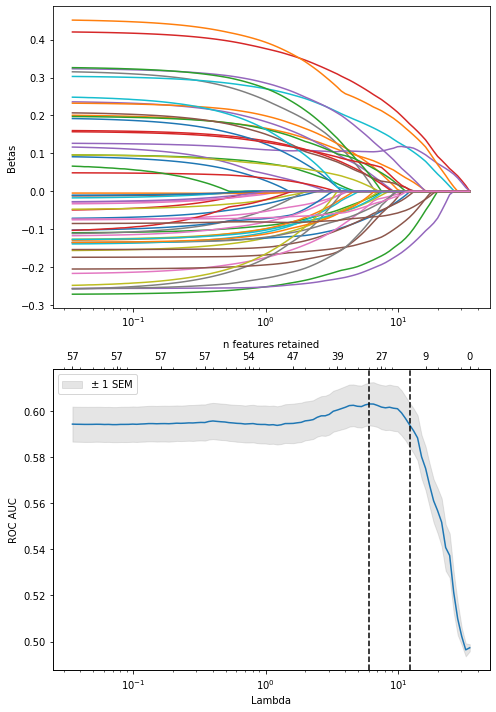

In [12]:
ax1, ax2, ax22 = plot_regularization_path(1/Cs_lasso_nefritis, coefs_lasso_nefritis, nnz_coefs_lasso_nefritis, lasso_nefritis.cv_results_)
#ax22.set_ylim([0.8, 1])

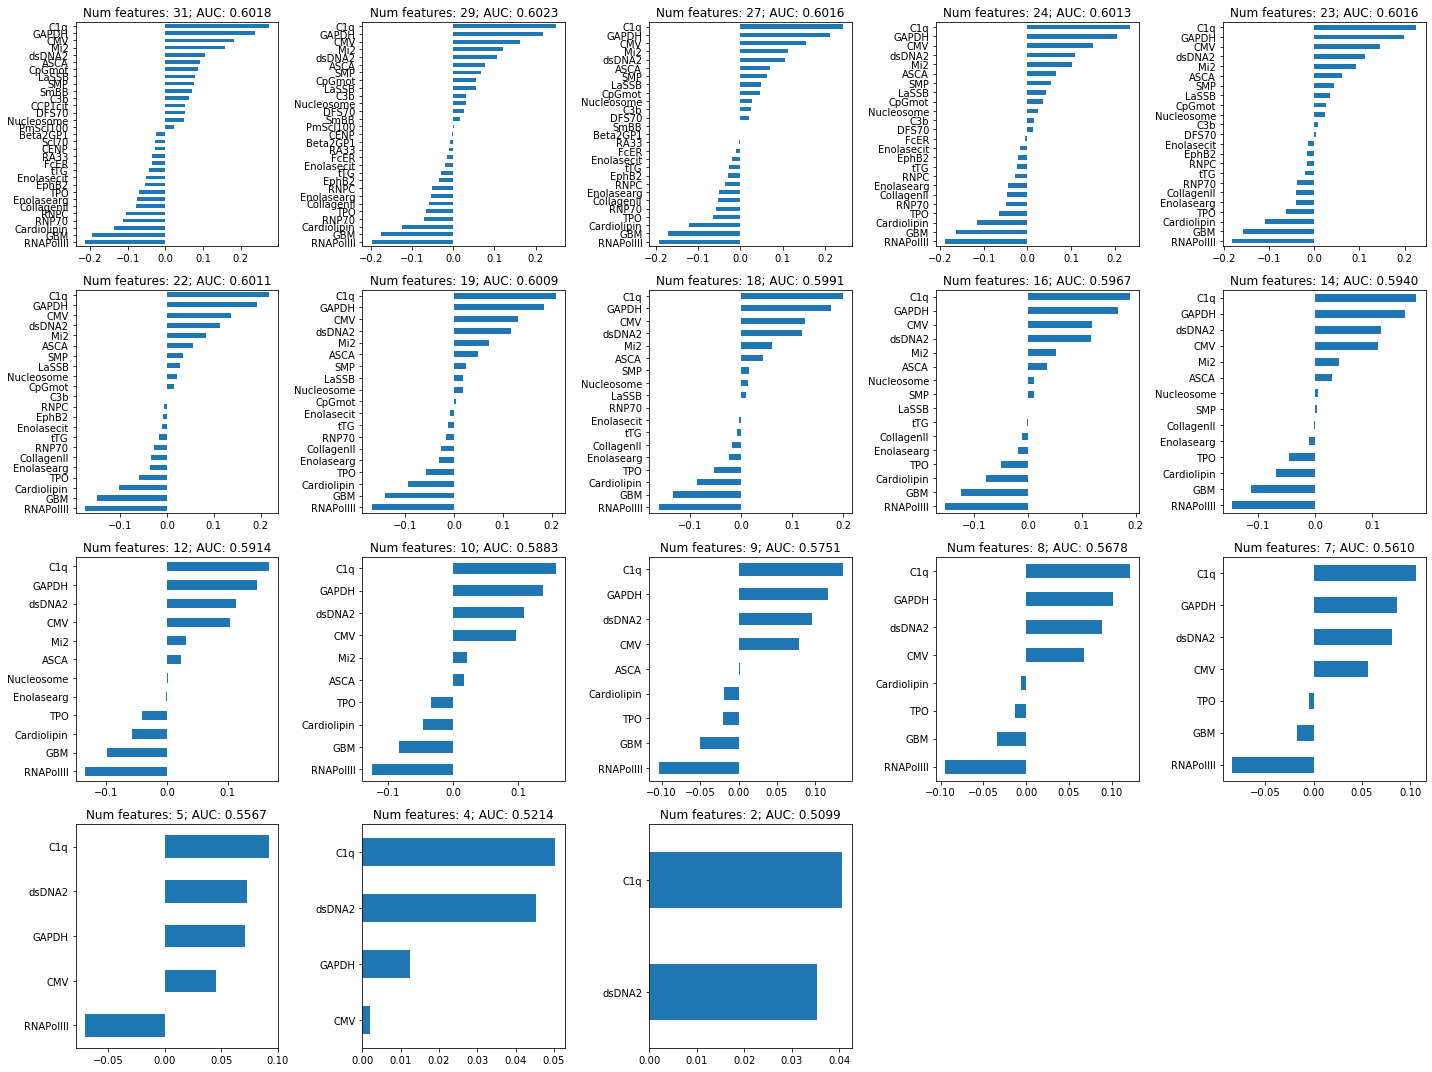

In [13]:
#| column: page
coef_plots_regularized(coefs_lasso_nefritis, nnz_coefs_lasso_nefritis, lasso_nefritis.cv_results_["mean_test_score"], varnames=Xp1_nefritis.columns)

Non-zero coefficients of the model selected with the 1SE rule:

In [14]:
(pd.Series(lasso_nefritis.best_estimator_.named_steps.clf.coef_.squeeze(), index = X_nefritis.columns)[lambda x: x!=0].sort_values(ascending=False))

C1q            0.177918
GAPDH          0.157594
dsDNA2         0.116051
CMV            0.110894
Mi2            0.041954
ASCA           0.030033
Nucleosome     0.005160
SMP            0.003712
CollagenII    -0.001279
Enolasearg    -0.009766
TPO           -0.046097
Cardiolipin   -0.068313
GBM           -0.112145
RNAPolIII     -0.144926
dtype: float64